In [ ]:
#Import TensorFlow preloaded ResNet 101 model
from tensorflow.keras.applications import ResNet101

In [ ]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
pip install split-folders tqdm

In [ ]:
!unzip /content/drive/MyDrive/SimulatedData.zip -d /content/final_data

In [ ]:
#Split into train & test and validation
import splitfolders
splitfolders.ratio('/content/final_data/SimulatedData', output="output", seed=1337, ratio=(0.8, 0.1, 0.1)) 

Copying files: 100913 files [00:35, 2847.48 files/s]


In [ ]:
basetrain_dir = '/content/output/train/'
training_dir = pathlib.Path(basetrain_dir)
baseval_dir = '/content/output/val/'
validation_dir = pathlib.Path(baseval_dir)
basetest_dir = '/content/output/test/'
test_dir = pathlib.Path(basetest_dir)

In [ ]:
#Set batch size, image height and image width
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
#Create image data generator to augment images
from keras.preprocessing.image import ImageDataGenerator
data_aug = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range = 0.1, height_shift_range = 0.1, 	shear_range=1.2, zoom_range=0.25, rotation_range=360)

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
#Create train, validation, confirmation image data generators
train_ds = data_aug.flow_from_directory(
	training_dir,  
	target_size=(img_height, img_width),  
	batch_size = batch_size,
	class_mode='binary')

Found 80730 images belonging to 2 classes.


In [ ]:
validation_ds = test_gen.flow_from_directory(
	validation_dir,
	target_size=(img_height, img_width),
	batch_size = batch_size,
	class_mode='binary')

Found 10090 images belonging to 2 classes.


In [ ]:
confirmation_generator = test_gen.flow_from_directory(
  test_dir,
	target_size = (img_height, img_width),
	batch_size = batch_size,
	class_mode=None,
	shuffle=False)

Found 10093 images belonging to 2 classes.


Model

In [ ]:
#Construct model from pre-imported model without ImageNet weights
sim_model = Sequential()

ResNet_101 = ResNet101(include_top = False, 
                     weights = None,
                     input_shape = (256, 256, 3),
                     pooling = 'max',
                     classes = 2)
#Set it to be trainable & add regularization
ResNet_101.trainable = True
ResNet_101 = add_regularization(ResNet_101)
#Add output layers to model
sim_model.add(ResNet_101)
sim_model.add(Flatten())
sim_model.add(Dense(512, activation = 'relu'))
sim_model.add(Dense(1, activation = 'sigmoid'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
import os
import tempfile
#Regularization code modified from: https://sthalles.github.io/keras-regularizer/
def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [ ]:
sim_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 1)                513       
 pper)                                                           
                                                                 
Total params: 43,707,777
Trainable params: 43,602,433
Non-trainable params: 105,344
______________________________________

In [ ]:
#Compile model
sim_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
#Train model
epochs = 11
history = sim_model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = epochs
)

Epoch 1/11
2523/2523 [==============================] - 1473s 575ms/step - loss: 3.6704 - accuracy: 0.9739 - val_loss: 3.4673 - val_accuracy: 0.9984
Epoch 2/11
2523/2523 [==============================] - 1451s 575ms/step - loss: 3.2319 - accuracy: 0.9962 - val_loss: 2.8945 - val_accuracy: 0.9982
Epoch 3/11
2523/2523 [==============================] - 1441s 571ms/step - loss: 2.4013 - accuracy: 0.9979 - val_loss: 3.6136 - val_accuracy: 0.5470
Epoch 4/11
2523/2523 [==============================] - 1429s 566ms/step - loss: 1.3273 - accuracy: 0.9964 - val_loss: 1.0340 - val_accuracy: 0.9414
Epoch 5/11
2523/2523 [==============================] - 1430s 567ms/step - loss: 0.6532 - accuracy: 0.9984 - val_loss: 0.4546 - val_accuracy: 0.9991
Epoch 6/11
2523/2523 [==============================] - 1427s 566ms/step - loss: 0.3625 - accuracy: 0.9986 - val_loss: 0.2781 - val_accuracy: 0.9986
Epoch 7/11
2523/2523 [==============================] - 1432s 567ms/step - loss: 0.2513 - accuracy: 0.9983

Evaluation

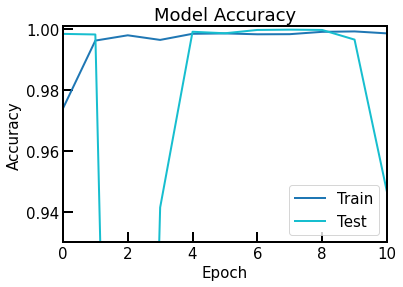

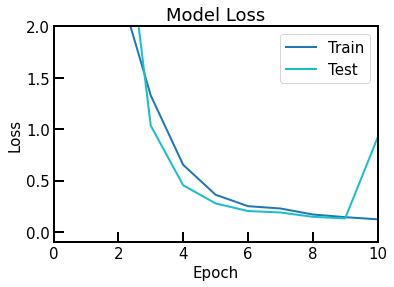

In [ ]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm
import matplotlib.font_manager as fm

#accuracy
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2
colors = cm.get_cmap('tab10', 2)
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.plot(history.history['accuracy'], color = colors(0), linewidth = 2)
ax.plot(history.history['val_accuracy'], color = colors(1), linewidth = 2)
ax.set_ylim(0.93, 1.0009)
ax.set_xlim(0, 10)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

#loss
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2
colors = cm.get_cmap('tab10', 2)
fig = plt.figure(figsize=(4.5, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in')
ax.plot(history.history['loss'], color = colors(0), linewidth = 2)
ax.plot(history.history['val_loss'], color = colors(1), linewidth = 2)
ax.set_ylim(-0.1, 2)
ax.set_xlim(0, 10)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
def get_predictions(generator,model):
	test_steps_per_epoch = np.math.ceil(generator.samples / generator.batch_size)
	predictions = model.predict_generator(generator, steps=test_steps_per_epoch)
	predictions = [i[0] for i in predictions]
	predictions = np.array(predictions)
	return predictions


def prediction_report(predictions,generator,cutoff,chatter=False):
	predicted_classes = np.copy(predictions)
	predicted_classes[predicted_classes>cutoff] = 1.0
	predicted_classes[predicted_classes<cutoff] = 0.0 
	true_classes = generator.classes
	N_ring = len(np.where(true_classes>0.5)[0])
	N_normal = len(np.where(true_classes<0.5)[0])
	tn, fp, fn, tp = confusion_matrix(true_classes,predicted_classes).ravel()
	matrix = confusion_matrix(true_classes,predicted_classes)
	if chatter:
		print('True Normal predictions: {} | ({} percent)'.format(tn,(tn * 100)/N_normal))
		print('True Ring predictions: {} | ({} percent)'.format(tp,(tp * 100)/N_ring))
		print('False Normal predictions (actually Ring): {} | ({} percent)'.format(fn,(fn * 100)/N_ring))
		print('False Ring predictions (actually Normal): {} | ({} percent)'.format(fp,(fp * 100)/N_normal))
	return(tn, fp, fn, tp)

def MCC(theta):
	tn, fp, fn, tp = theta
	numerator = (tp*tn) - (fp*fn)
	denomenator = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
	MCC = numerator / denomenator
	return MCC

def AUC(predictions,generator):
	thresholds = np.linspace(0.0,1,20)
	tprs = []
	fprs = []
	for i in thresholds:
		tn, fp, fn, tp = prediction_report(predictions,generator,cutoff=i,chatter=False)
		TPR = tp / (fn+tp)
		FPR = fp / (fp+tn)
		tprs.append(TPR)
		fprs.append(FPR)
	tprs = np.array(tprs)[::-1]
	fprs = np.array(fprs)[::-1]
	plt.plot(fprs,tprs)
	plt.plot([0,1],[0,1],'k')
	area = np.trapz(tprs,x=fprs)
	print("Area under the curve: {}".format(area))
	return area


In [ ]:
sim_model.evaluate(confirmation_generator)

316/316 [==============================] - 32s 91ms/step - loss: 0.1133 - accuracy: 0.0000e+00


[0.11328666657209396, 0.0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


True Normal predictions: 4614 | (90.5771495877503 percent)
True Ring predictions: 4989 | (99.7999599919984 percent)
False Normal predictions (actually Ring): 10 | (0.20004000800160032 percent)
False Ring predictions (actually Normal): 480 | (9.422850412249705 percent)
MCC:  0.9069150563776822
Area under the curve: 0.9756923705117937


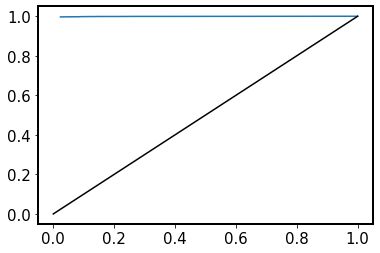

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = get_predictions(confirmation_generator,sim_model)
theta = prediction_report(predictions,confirmation_generator,cutoff=0.5,chatter=True)
mcc = MCC(theta)
print('MCC: ',mcc)
area_under_curve = AUC(predictions,confirmation_generator)
#print(area_under_curve)

In [ ]:
sim_model.save("RingNetSim101")

INFO:tensorflow:Assets written to: RingNetSim101/assets


INFO:tensorflow:Assets written to: RingNetSim101/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
